In [1]:
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as func
from torch.utils.data import TensorDataset, DataLoader, random_split, Dataset
from torchvision import transforms

The python code below will unzip the data zipfile and load it into memory automatically. You only need to set the correct path to the zipfile.

In [2]:
import zipfile
with zipfile.ZipFile("/content/MNIST_synthetic.zip") as zip_ref:
    zip_ref.extractall("/content/mnist")

In [3]:
f = h5py.File('/content/mnist/MNIST_synthetic.h5', 'r')

In [32]:
train_input = torch.from_numpy(np.array(f['train_dataset'], dtype=np.float32).reshape((-1, 1, 64, 64)) / 255)
train_labels = torch.from_numpy(np.array(f['train_labels'], dtype=np.long))
test_input = torch.from_numpy(np.array(f['test_dataset'], dtype=np.float32).reshape((-1, 1, 64, 64)) / 255)

In [6]:
class TrainDataset(Dataset):
    def __init__(self, train_input, train_labels):
        self.train_input = train_input
        self.train_labels = train_labels
    
    def __len__(self):
        return self.train_input.shape[0]
    
    def __getitem__(self, idx):
        return self.train_input[idx], self.train_labels[idx]

class TestDataset(Dataset):
    def __init__(self, test_input):
        self.test_input = test_input

    def __len__(self):
        return self.test_input.shape[0]

    def __getitem__(self, idx):
        return self.test_input[idx]

In [34]:
train_dataset = TrainDataset(train_input, train_labels)
test_dataset = TestDataset(test_input)

n_val = int(0.15 * len(train_dataset))
train, val = random_split(train_dataset, [len(train_dataset) - n_val, n_val], generator=torch.Generator().manual_seed(10))

train_loader = DataLoader(train, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val, batch_size=1024)
test_loader = DataLoader(test_dataset, batch_size=1024, num_workers=0)

Example of an image

torch.Size([32, 1, 64, 64])


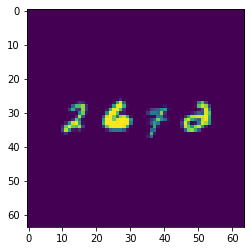

In [19]:
img, lbl = next(iter(train_loader))
print(img.shape)
plt.imshow(np.array(img[0][0].reshape((64,64))))

The GPU being used

In [20]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla V100-SXM2-16GB


The basic building block to our residual network

In [25]:
#inspired by the pytorch resnet model https://github.com/pytorch/vision/blob/aa753263b8e7b3180225e3ad1e6e5434a5f42882/torchvision/models/resnet.py#L37

class ResBlock(nn.Module):
    def __init__(self, channels_in, channels_out, stride=1, downsample=False):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(channels_out)
        self.relu = nn.ReLU(inplace=True)
        self.bnId = nn.BatchNorm2d(channels_out)
        self.downsample = downsample
        self.downsampler = nn.Conv2d(channels_in, channels_out, kernel_size=1, stride=2, bias=False)
    
    def forward(self, x):
        id = x
        x = self.conv1(x)
        x = self.bn1(x)

        if self.downsample:
            id = self.downsampler(id)
            id = self.bnId(id)
    
        x += id
        x = self.relu(x)
        return x

Our architecture

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.b1 = ResBlock(1, 32)
        self.b12 = ResBlock(32, 32)

        self.b2 = ResBlock(32, 64, stride=2, downsample=True)  # 32x32
        self.b22 = ResBlock(64, 64)
        self.b23 = ResBlock(64, 64)
        self.b24 = ResBlock(64, 64)
        self.b25 = ResBlock(64, 64)
        self.b26 = ResBlock(64, 64)

        self.b3 = ResBlock(64, 128, stride=2, downsample=True)  # 16x16
        self.b32 = ResBlock(128, 128)
        self.b33 = ResBlock(128, 128)
        self.b34 = ResBlock(128, 128)
        self.b35 = ResBlock(128, 128)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(128 * 1 * 1, 11 * 5)
    
    def forward(self, x):
        x = self.b1(x)
        x = self.b12(x)

        x = self.b2(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)

        x = self.b3(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)

        x = self.avg(x)
        x = x.view(-1, 128 * 1 * 1)
        x = self.fc(x)
        return x

net = Net().cuda()

SGD optimizer with a scheduler that reduces the learning rate whenever the accuracy doesn't improve for 3 epochs.

In [27]:
# Define optimizers
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=.90,patience=3, threshold=.01, verbose=False)
# Define the loss
loss = nn.CrossEntropyLoss()

In [28]:
# Training and validation loop
n_epochs = 50
accuracies = []
train_accuracies = []
best_net_state = None
best_accuracy = 0
for epoch in range(n_epochs):
    net.train()
    train_losses = []
    train_total = 0
    train_correct = 0
    for batch in train_loader:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        # logits
        l = net(x)
        # loss
        #   for multi-label-multi-class, cross entropy needs the input to be of shape (batchsize, nClasses, nLabels)
        #   so we make a view of shape (batchsize, nLabels, nClasses) and transpose on axis 1 and 2.
        j = loss(l.view(-1, 5, 11).transpose(1, 2), y)
        # Training accuracy
        with torch.no_grad():
            y_hat = torch.argmax(l.view(-1, 5, 11), dim=-1)
            train_total += y_hat.size(0)
            train_correct += (y_hat == y).all(-1).sum().item()
        # reset gradient
        optimizer.zero_grad()
        # caculate gradient
        j.backward()
        # update parameter weights
        optimizer.step()
        # add loss for this epoch
        train_losses.append(j.item())
    train_accuracies.append(100 * train_correct / train_total)

    # Validation
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x = x.cuda()
            outputs = net(x).cpu()
            y_hat = torch.argmax(outputs.view(-1, 5, 11), dim=-1)
            total += y_hat.size(0)
            correct += (y_hat == y).all(-1).sum().item()
    accuracy = 100 * correct / total
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_net_state = net.state_dict()
    print(f'Epoch {epoch + 1}, train loss: {np.array(train_losses).mean():.6f}, val acc: {accuracy:.3f}')
    accuracies.append(accuracy)
    scheduler.step(accuracy)

print(f"Best accuracy: {best_accuracy}")

Epoch 1, train loss: 0.801602, val acc: 60.143
Epoch 2, train loss: 0.190099, val acc: 64.738
Epoch 3, train loss: 0.053128, val acc: 83.167
Epoch 4, train loss: 0.030108, val acc: 96.262
Epoch 5, train loss: 0.020094, val acc: 98.000
Epoch 6, train loss: 0.014746, val acc: 95.071
Epoch 7, train loss: 0.010920, val acc: 72.321
Epoch 8, train loss: 0.008278, val acc: 97.940
Epoch 9, train loss: 0.007322, val acc: 98.762
Epoch 10, train loss: 0.003645, val acc: 99.250
Epoch 11, train loss: 0.002422, val acc: 98.869
Epoch 12, train loss: 0.002185, val acc: 99.321
Epoch 13, train loss: 0.002213, val acc: 99.250
Epoch 14, train loss: 0.001407, val acc: 99.429
Epoch 15, train loss: 0.001026, val acc: 99.500
Epoch 16, train loss: 0.000685, val acc: 99.619
Epoch 17, train loss: 0.000587, val acc: 99.643
Epoch 18, train loss: 0.000510, val acc: 99.667
Epoch 19, train loss: 0.000478, val acc: 99.667
Epoch 20, train loss: 0.000441, val acc: 99.714
Epoch 21, train loss: 0.000396, val acc: 99.667
E

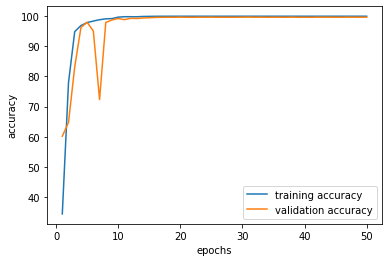

In [29]:
plt.plot(np.arange(1, n_epochs + 1), train_accuracies, label="training accuracy")
plt.plot(np.arange(1, n_epochs + 1), accuracies, label="validation accuracy")
plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

Below code for saving the model and building the sample.csv file for Kaggle.

In [30]:
# save the trained model
torch.save(best_net_state, '/content/net.pth')
best_net = Net()
state_dict = torch.load('/content/net.pth')
best_net.load_state_dict(state_dict)
best_net.eval()
best_net.cuda()

Net(
  (b1): ResBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (bnId): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsampler): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
  )
  (b12): ResBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (bnId): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsampler): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
  )
  (b2): ResBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU

In [35]:
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x = batch
        x = x.cuda()
        outputs = net(x)
        y_hat = torch.argmax(outputs.view(-1, 5, 11), dim=-1).cpu()
        predictions += y_hat.tolist()

In [36]:
import pandas as pd
predictions_formatted = []
for pred in predictions:
    pred_str = [str(i) for i in pred]
    predictions_formatted.append("".join(pred_str))

In [37]:
df = pd.DataFrame()
df["Id"] = np.arange(len(predictions_formatted))
df["Label"] = predictions_formatted
print(df)
df.to_csv("sample.csv", index=False)

          Id      Label
0          0  910101010
1          1     017310
2          2      14083
3          3  010101010
4          4     467810
...      ...        ...
13995  13995  110101010
13996  13996     604110
13997  13997  310101010
13998  13998     419710
13999  13999      58309

[14000 rows x 2 columns]
